# Tutorial for mapping data with Tangram

by Tommaso Biancalani biancalt@gene.com and Ziqing Lu luz21@gene.com
- 该 notebook 介绍了使用 Tangram 方法将单细胞数据映射到空间数据。
- 该 notebook 使用来自小鼠大脑皮层的数据（与手稿中采用的数据不同）。

**Last changelog**
- June 13th - Tommaso Biancalani biancalt@gene.com

## Installation

- 确保 `tangram-sc` 已通过 `pip install tangram-sc` 安装。
- 否则，编辑并取消注释以 `sys.path` 开头的指定 Tangram 文件夹的行。
- Python 环境需要安装 `environment.yml` 中列出的包。

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
sys.path.append('./')  # uncomment for local import
import tangram as tg

%load_ext autoreload
%autoreload 2
%matplotlib inline

tg.__version__

'1.0.4'

## Download the data

- 如果你安装了 `wget`，则可以运行以下代码自动下载并解压数据。

In [ ]:
# Skip this cells if data are already downloaded
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz -O data/mop_sn_tutorial.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz -O data/slideseq_MOp_1217.h5ad.gz
!wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv -O data/MOp_markers.csv
!gunzip -f data/mop_sn_tutorial.h5ad.gz
!gunzip -f data/slideseq_MOp_1217.h5ad.gz

- 如果您没有安装 `wget`，请从以下链接手动下载数据：
    - 从成年小鼠皮质收集的 snRNA-seq 数据集：[10Xv3 MOp](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz)
    - 对于空间数据，我们将使用 [Slide-seq2 data](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz) 的一个冠状切片(adult mouse brain; MOp area)。
    - 我们将通过[文献](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1)中发现的数百个 [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv) 来绘制它们。
    - 所有数据集都需要解压缩：生成的 `h5ad` 和 `csv` 文件应放置在数据文件夹中。

## Load spatial data

- 空间数据需要组织为一个 voxel-by-gene 矩阵。这里，Slide-seq 数据包含 9852 个空间 voxels，每个空间 voxels 测量 24518 个基因。

In [3]:
path = os.path.join('./data/without', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- voxel 坐标保存在 `obs.x` 和 `obs.y` 字段中，我们可以使用它们来可视化空间 ROI。每个“点”都是 10um voxel 的中心。

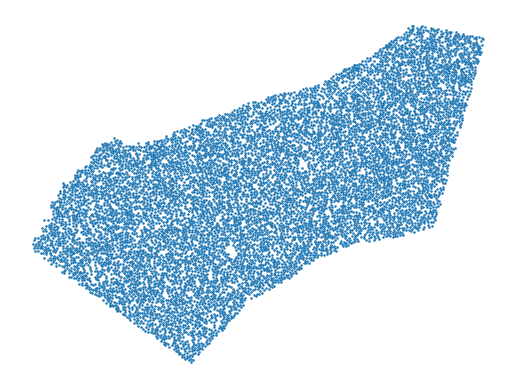

In [4]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()

## Single cell data

- 对于单细胞数据，我们通常指的是 scRNAseq 或 snRNAseq。
- 我们首先 mapping MOp 10Xv3 数据集，其中包含从初级运动皮层后部区域收集的单核。
- 它们是大约 26k 个具有 28k 个基因的 profiled 细胞。

In [5]:
path = os.path.join('data/without','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 26431 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

- 通常，我们使用 raw count 形式的数据，特别是当空间数据也采用 raw count 形式时。
- 如果数据采用整数格式，则可能意味着它们是原始计数。

In [6]:
np.unique(ad_sc.X.toarray()[0, :])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  33.,
        34.,  36.,  39.,  40.,  43.,  44.,  46.,  47.,  49.,  50.,  53.,
        56.,  57.,  58.,  62.,  68.,  69.,  73.,  77.,  80.,  85.,  86.,
        98., 104., 105., 118., 121., 126., 613.], dtype=float32)

- 在这里，我们只进行一些轻微的预处理作为库大小校正（在 scanpy 中，通过 `sc.pp.normalize`），将每个细胞内的计数标准化为固定数字。
- 有时，我们会应用更复杂的预处理方法，例如批量校正，尽管映射对于原始数据效果很好。
- 理想情况下，单细胞和空间数据集应表现出尽可能相似的信号，并且应最终确定预处理管道以协调信号。

In [7]:
sc.pp.normalize_total(ad_sc)

- 在单细胞数据中添加注释是个好主意，因为在我们 map 后它们将被投影到空间上。
- 在这种情况下，细胞类型在 `subclass_label` 字段中进行注释，我们为其绘制细胞计数。
- 请注意，两个数据集中的细胞类型比例应该相似：例如，如果 `Meis` 在 snRNA-seq 中是一种罕见的细胞类型，那么即使在空间数据中，它也应该是一种罕见的细胞类型。

In [8]:
ad_sc.obs.subclass_label.value_counts()

subclass_label
L5 IT        5623
Oligo        4330
L2/3 IT      3555
L6 CT        3118
Astro        2600
Micro-PVM    1121
Pvalb         972
L6 IT         919
L5 ET         903
L5/6 NP       649
Sst           627
Vip           435
L6b           361
Endo          357
Lamp5         332
VLMC          248
Peri          187
Sncg           94
Name: count, dtype: int64

## Prepare to map

- Tangram 学习单细胞数据的空间对齐，以便对齐的单细胞数据的基因表达与空间数据的基因表达尽可能相似。
- 在此过程中，Tangram 仅查看用户指定的子集基因，称为训练基因。
- 训练基因的选择是 mapping 的一个微妙步骤：它们需要承载有趣的信号并进行高质量的测量。
- 通常，一个好的开始是选择 100-1000 个 top marker genes，在不同细胞类型之间均匀分层。有时，我们还使用整个转录组，或使用不同的训练基因组执行不同的映射，以查看结果变化有多大。
- 对于本例，我们选择了 MOp 区域的 253 个 marker genes，这些基因是在另一项[研究](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1)中策划的。

In [9]:
df_genes = pd.read_csv('data/without/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

- 现在，我们需要通过在两个 AnnData 结构的 `uns` 字典中创建 `training_genes` 字段来准备用于 mapping 的数据集。
- 该 `training_genes` 字段包含训练基因列表中的基因子集。稍后将在映射函数中使用该字段来创建训练数据集。
- 此外，数据集中的基因顺序需要相同。这是因为 Tangram maps 只使用基因表达，所以每个矩阵中的第 j-th 列必须对应于相同的基因。
- 如果某个基因的计数在其中一个数据集中全部为零，则该基因将从训练基因中删除。
- 此任务由辅助函数 `pp_adata` 执行。
- 在 `pp_adatas` 函数中，基因名称被转换为小写，以消除不一致的大写。如果不需要，可以设置参数 `gene_to_lowercase=False`。

In [10]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)

INFO:root:249 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


- 您现在会注意到，这两个数据集现在包含 249 个基因，但提供了 253 个标记。
- 这是因为标记基因需要由两个数据集共享。如果一个基因缺失，`pp_adata` 就会将其删除。
- 最后，下面的 `assert` 行是确保 `uns` 中 `training_genes` 字段中的基因在两个 `AnData` 中实际排序的好方法。

In [11]:
ad_sc

AnnData object with n_obs × n_vars = 26431 × 26496
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'
    layers: 'logcounts'

In [12]:
ad_sp

AnnData object with n_obs × n_vars = 9852 × 20864
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'

In [13]:
assert ad_sc.uns['training_genes'] == ad_sp.uns['training_genes']

## Map

- 我们现在可以训练模型（把单细胞的数据映射到空间上）。
- 应在分数稳定后中断映射，这可以通过传递 `num_epochs` 参数来控制。
- 该分数衡量映射细胞的基因表达与空间数据之间的相似性：分数越高意味着映射越好。
- 请注意，即使 Tangram 收敛到较低的分数（典型的情况是当空间数据非常稀疏时），我们也获得了极好的映射：我们使用分数只是为了评估收敛性。
- 如果您使用 GPU 运行 Tangram，请取消对 `device=cuda:0` 的注释，并对 `device=cpu` 行进行注释。在 MacBook Pro 2018 上，运行大约需要 1 小时。在 P100 GPU 上，它应该在几分钟内完成。

In [14]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp,
    #device='cpu',
    device='cuda:0',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 249 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.103, KL reg: 0.558


OutOfMemoryError: CUDA out of memory. Tried to allocate 994.00 MiB (GPU 0; 6.00 GiB total capacity; 4.90 GiB already allocated; 0 bytes free; 5.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

- 映射结果存储在返回的 `AnData` 结构中，另存为 `ad_map`，结构如下：
    - cell-by-spot 矩阵 `X` 包含 cell i 在 spot j 的概率。
    - `obs` dataframe 包含单细胞的 metadata。
    - `var` dataframe 包含空间组数据的 metadata。
    - `uns` 字典包含具有关于训练基因的各种信息的 dataframe（保存为 `train_genes_df`）。
- 我们现在可以保存映射结果以进行后期分析。

## Analysis

- 将单细胞数据映射到空间上最常见的应用程序是将细胞类型注释 transfer 到空间上。
- 这是通过 `plot_cell_anotation` 实现的，它可视化了 `obs` dataframe 中注释的空间概率映射（此处为 `subclass_label` 字段）。您可以将 `robust` 参数设置为 `True`，同时将 `perc` 参数设置为 colormap 的范围，这将有助于删除异常值。
- 下图恢复了兴奋性神经元的皮质层和神经胶质细胞的稀疏模式。皮质的边界由 layer 6b （细胞类型 L6b）定义，并且发现少突胶质细胞集中在皮质下区域，正如预期的那样。
- 然而，VLMC 细胞类型模式似乎并不正确：VLMC 细胞聚集在第一皮质层，而此处在 ROI 中稀疏。这通常意味着（1）我们在训练基因中没有为 VLMC 细胞使用良好的标记基因（2）当前的标记基因在空间数据中非常稀疏，因此它们不包含良好的映射信号。

In [ ]:
tg.project_cell_annotations(ad_map, ad_sp, annotation='subclass_label')
annotation_list = list(pd.unique(ad_sc.obs['subclass_label']))
tg.plot_cell_annotation_sc(ad_sp, annotation_list,x='x', y='y',spot_size= 60, scale_factor=0.1, perc=0.001)

- 让我们尝试更深入地了解这个映射有多好。一个好帮手是 `plot_training_scores`，它为我们提供了四个面板：
    - 第一个面板是每个训练基因的相似性得分的直方图。大多数基因都具有非常高的相似性 (> 0.9)，尽管其中很少有得分低于 0.5。我们想了解为什么这些基因的得分较低。
    - 第二张图显示，基因的训练得分（y 轴）与 snRNA-seq 数据中该基因的稀疏性（x 轴）之间存在紧密的相关性。每个点都是一个训练基因。趋势是基因越稀疏，得分越高：这种情况通常会发生，因为非常稀疏的基因更容易映射，因为通过在正确的位置放置一些 "jackpot cells" 来匹配它们的模式。
    - 第三个面板与第二个面板类似，但包含空间数据的基因稀疏性。空间数据通常比单细胞数据更加稀疏，这种差异通常是造成低质量映射的原因。
    - 在最后一个面板中，我们将训练分数显示为数据集之间稀疏度差异的函数。对于具有相当稀疏性的基因，映射的基因表达与空间数据中的基因表达非常相似。然而，如果某个基因在一个数据集中（通常是空间数据）非常稀疏，但在其他数据集中则不然，则映射分数会较低。出现这种情况是因为 Tangram 无法正确匹配基因模式，因为数据集之间的丢失数量不一致。

In [ ]:
tg.plot_training_scores(ad_map, bins=10, alpha=.5)

- 尽管上图为我们提供了单基因水平的分数摘要，但我们需要知道哪些基因的分数较低。
- 这些信息可以从映射结果的 dataframe `.uns['train_genes_df']` 访问；这是用于构建上面四个图的 dataframe。
- 我们想要检查低分映射的训练基因的基因表达，以了解映射的质量。
- 首先，我们需要使用映射的单细胞生成“新的空间数据”：这是通过 `project_genes` 完成的。
- 该函数接受映射 (`adata_map`) 和相应的单细胞数据 (`adata_sc`) 作为输入。
- 结果是一个 voxel-by-gene `AnnData`，形式上类似于 `ad_sp`，但包含来自映射的单细胞数据而不是 Slide-seq 的基因表达。

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

- 我们现在选择一些低分映射的训练基因。

In [ ]:
genes = ['rgs6', 'satb2',  'cdh12']
ad_map.uns['train_genes_df'].loc[genes]

- 为了可视化基因模式，我们使用辅助程序 `plot_genes`。该函数接受两个 voxel-by-gene `AnnData`：实际空间数据 (`adata_measured`) 和 Tangram 空间预测 (`adata_predicted`)。该函数从基因上的两个空间 `AnnData` 返回基因表达图。
- 正如预期的那样，尽管捕获了主要模式，但预测的基因表达不太稀疏。对于这些基因，我们更信任映射的基因模式，因为 Tangram 通过在空间中对齐稀疏数据来“纠正”基因表达。

In [ ]:
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc = 0.001, return_figure=False)

- 一个更强有力的例子是在空间数据中未检测到但在单细胞数据中检测到的基因。在使用 `pp_adatas` 函数进行训练之前将它们删除。但 Tangram 仍然可以产生对空间模式的洞察。

In [ ]:
genes=['mrgprx2', 'muc20', 'chrna2']
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)

- 到目前为止，我们只检查了用于对齐数据的基因（训练基因），但映射的单细胞数据 `ad_ge` 包含整个转录组。其中包括超过 26k 个测试基因。

In [ ]:
(ad_ge.var.is_training == False).sum()

- 我们可以使用 `plot_genes` 来检查非训练基因的基因表达。这是一个重要的步骤，因为基因表达的预测是我们验证映射的方式。
- 在此之前，可以方便地计算所有基因的相似性分数，这可以通过 `compare_spatial_geneexp` 来完成。该函数接受两个空间 `AnnData`（即 voxel-by-gene），并返回一个包含所有基因相似度分数的 dataframe。训练基因由布尔字段 `is_training` 标记。
- 如果我们还将单细胞 `AnnData` 传递给 `Compare_spatial_geneexp` 函数，如下所示，则会返回带有附加稀疏列的 dataframe - sparsity_sc（单细胞数据稀疏度）和 sparsity_diff （空间数据稀疏度 - 单细胞数据稀疏度）。如果我们想稍后使用从 `compare_spatial_geneexp` 函数返回的 datafrme 调用 `plot_test_scores` 函数，这是必需的。

In [ ]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, ad_sp, ad_sc)
df_all_genes

- 下图总结了测试基因在单基因水平上的得分

In [ ]:
tg.plot_auc(df_all_genes)

- 让我们绘制测试基因的分数，看看它们与训练基因的比较如何。按照前面图中的策略，我们将分数可视化为空间数据稀疏性的函数。
- （我们还没有将此调用包装到函数中）。
- 同样，空间数据中稀疏基因的预测得分较低，这是由于空间数据中存在丢失。
- 让我们选择一些具有不同分数的测试基因，并将预测与测量的基因表达进行比较。

In [ ]:
genes = ['snap25', 'atp1b1', 'atp1a3', 'ctgf', 'nefh', 'aak1', 'fa2h', ]
df_all_genes.loc[genes]

- 我们可以再次使用 `plot_genes` 来可视化基因模式。
- 有趣的是，基因 `Atp1b1` 或 `Apt1a3` 的一致性似乎不如 `Ctgf` 和 `Nefh` 好，尽管前基因的得分较高。这是因为即使后面的基因模式定位正确，它们的表达值也没有很好的相关性（例如，在 Ctgf 中，“亮黄点”位于第 6b 层的不同部分）。相比之下，对于 Atpb1，尽管空间数据中的整体基因表达更加暗淡，但基因表达模式很大程度上恢复了。

In [ ]:
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)

## Leave-One-Out Cross Validation (LOOCV)

- 如果基因数量较少，Tangram 支持 Leave-One-Out cross validation (LOOCV) 来评估映射性能。
- Tangram 支持的 LOOCV：
    - 假设数据集中的基因数量为 N。
    - LOOCV 将迭代并映射基因数据集 N 次。
    - 每次它都会保留一个基因作为测试基因（1 test gene）并训练其余的所有基因（N-1 training genes）。
    - 所有训练完成后，将计算平均测试/训练分数以评估映射性能。
- 假设我们拥有的所有基因都是上例中的训练基因。在这里，我们演示了 cluster level 的 LOOCV 映射。
- 重新启动内核并加载单细胞、空间和基因标记数据
- 运行 `pp_adatas` 准备映射数据

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

In [2]:
path = os.path.join('./data/without', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)

path = os.path.join('data/without','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
sc.pp.normalize_total(ad_sc)

df_genes = pd.read_csv('data/without/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)

tg.pp_adatas(ad_sc, ad_sp, genes=markers)

INFO:root:249 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [3]:
cv_dict, ad_ge_cv, df = tg.cross_val(ad_sc, 
                                     ad_sp, 
                                     device='cuda:0', 
                                     mode='clusters',
                                     cv_mode='loo',
                                     num_epochs=1000,
                                     cluster_label='subclass_label',
                                     return_gene_pred=True,
                                     verbose=False,
                                     )

100%|█████████████████████████████████████████████████████████████████████████████████| 249/249 [27:36<00:00,  6.65s/it]

cv avg test score 0.185
cv avg train score 0.296


- `cross_val` 函数将在 `LOOCV` 模式下返回 `cv_dict` 和 `ad_ge_cv` 和 `df_test_genes`。`cv_dict` 包含交叉验证的平均分数，`ad_ge_cv` 存储每个基因的预测表达值，`df_test_genes` 包含每个测试基因的分数和稀疏度。

In [5]:
cv_dict

{'avg_test_score': 0.1850331576345662, 'avg_train_score': 0.2960305047561845}

- 我们可以使用 `plot_test_scores` 来显示每个基因与稀疏性的交叉验证测试分数的概述。

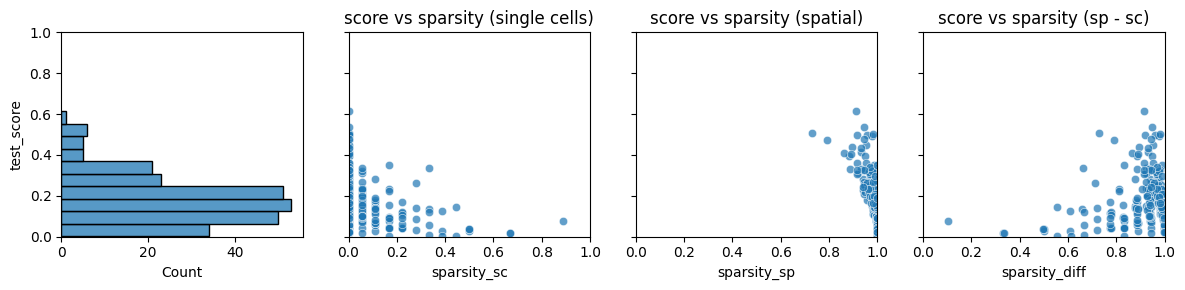

In [6]:
tg.plot_test_scores(df, bins=10, alpha=.7)

- 现在，让我们通过调用函数 `plot_genes` 来比较一些基因的真实情况和交叉验证预测的空间模式

In [7]:
ad_ge_cv.var.sort_values(by='test_score', ascending=False)

,test_score
gad1,0.612764
gad2,0.538277
slc17a7,0.507561
vtn,0.503789
pvalb,0.498317
...,...
5031425f14rik,0.015641
prok2,0.008920
teddm3,0.003747
scgn,0.002914


In [8]:
ranked_genes = list(ad_ge_cv.var.sort_values(by='test_score', ascending=False).index.values)
top_genes = ranked_genes[:3]
bottom_genes = ranked_genes[-3:]

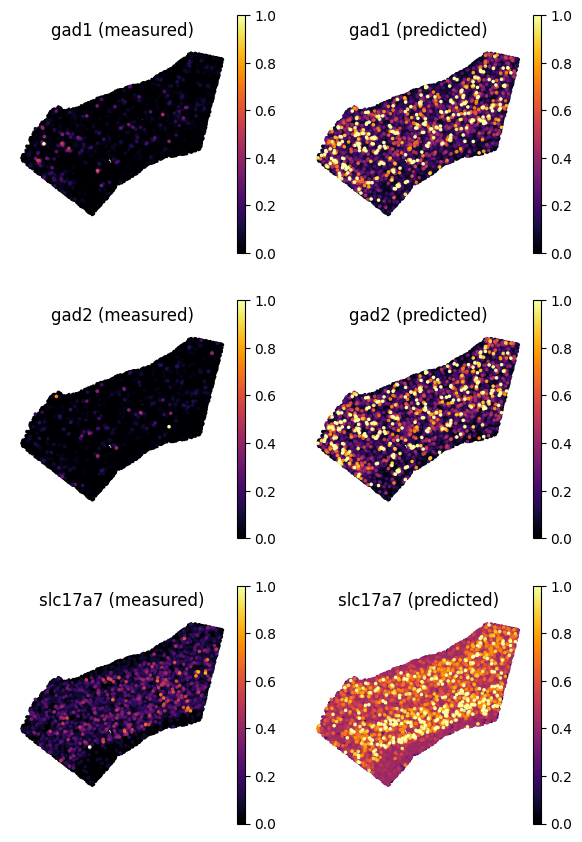

In [10]:
tg.plot_genes_sc(genes=top_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv, x = 'x', y='y',spot_size=50,scale_factor=0.1, perc=0.02, return_figure=False)

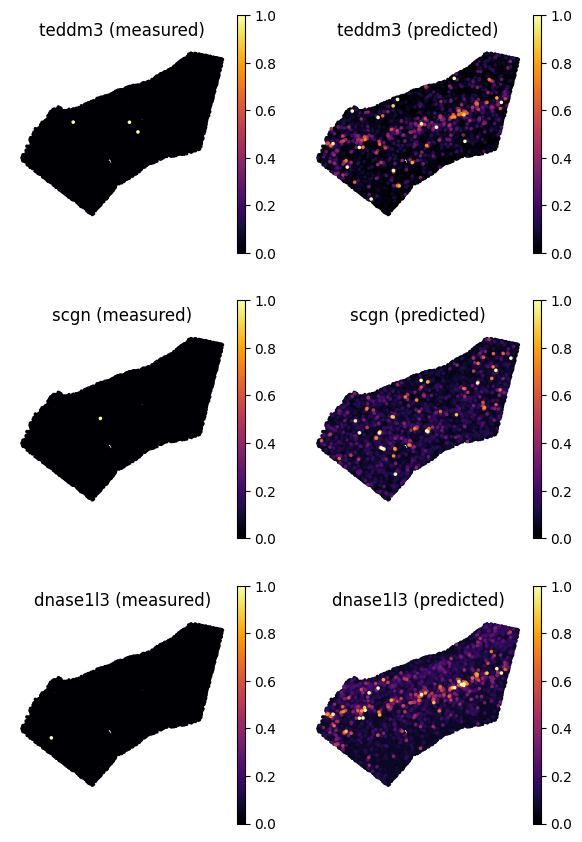

In [11]:
tg.plot_genes_sc(genes=bottom_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv,x='x', y='y', spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)